<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/Modell-Based-Coll-Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/Modell-Based-Coll-Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modell-Based-Coll-Filtering
** Authors **: Rafaella and Luca

In [28]:
!pip install --no-cache-dir scikit-surprise
!pip install implicit


## Setup

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
import implicit
from surprise import accuracy
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from google.colab import drive
drive.mount('/content/drive')
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

In [30]:
#Load data
data_sample_prep = pd.read_csv("/content/drive/MyDrive/Recommender/sample_preprocessed.csv")
data_sample_prep.head(100)

#Select Relevant Columns
data_sample_prep_sel = data_sample_prep[['user_id', 'media_id', 'is_listened']]  # Keep only necessary columns for the SVD model

In [ ]:
data_sample_prep.head(100)

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,...,days_since_release,genre_popularity,media_popularity,artist_popularity,album_popularity,songs_listened,song_popularity_7d,artist_popularity_7d,album_popularity_7d,month
0,10,2016-11-12 22:01:41,3092645,299421,1,2002-12-31,2,1,198,1,...,5065,12408,1,45,17,24,0,6,1,11
1,1129,2016-11-10 02:28:23,2247915,224543,0,2005-12-05,0,0,223,0,...,3993,249,11,309,16,66,2,46,2,11
2,10,2016-11-02 07:41:53,917717,103376,0,2005-08-22,0,0,201,0,...,4090,12408,13,21,17,87,1,1,1,11
3,0,2016-11-24 17:23:28,132625720,14101012,0,2016-09-23,0,0,187,0,...,62,168707,324,584,465,10,35,81,69,11
4,7,2016-11-11 11:55:23,921901,103798,0,1998-01-07,1,0,264,0,...,6883,42397,32,138,32,11,7,25,7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7,2016-11-01 16:42:12,2225892,222779,22,2004-12-31,2,1,262,0,...,4323,42397,1,1,1,7,0,0,0,11
96,723,2016-11-10 04:25:50,6744852,623660,0,2010-06-14,0,0,173,0,...,2341,730,1,3,1,104,0,0,0,11
97,7,2016-11-21 10:03:31,63103296,6197720,16,2011-06-13,2,1,265,0,...,1988,42397,2,148,32,5,1,26,8,11
98,297,2016-11-03 12:02:38,1044131,114005,3,1995-04-25,0,0,224,0,...,7863,6518,145,222,176,36,34,46,38,11


In [ ]:
#Convert to Surprise Dataset Format
reader = Reader(rating_scale=(0, 1))  #Binary values (0 = not heard, 1 = heard)
data = Dataset.load_from_df(data_sample_prep_sel[['user_id', 'media_id', 'is_listened']], reader)

#Split training and test data
trainset, testset = train_test_split(data, test_size=0.2)

## Model Training and Predictions

In [ ]:
#Initialize and train the SVD model
model = SVD(n_factors=50, reg_all=0.1, n_epochs=20)
model.fit(trainset)

#Generate Predictions on the Test Set
testset = trainset.build_testset()
predictions = model.test(testset)

## Threshold Optimization for F1 Score

In [ ]:
#Optimize Threshold for Best F1 Score
best_threshold = 0.5
best_f1 = 0

#Test thresholds between 0.1 and 0.9
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_true = [true_r for (_, _, true_r, _, _) in predictions]  # True labels
    y_pred = [1 if est >= threshold else 0 for (_, _, _, est, _) in predictions]  # Convert predictions to binary

    f1 = f1_score(y_true, y_pred, zero_division=1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n**Optimal Threshold for F1 Score: {best_threshold:.2f} with F1: {best_f1:.4f}**")


**Optimal Threshold for F1 Score: 0.50 with F1: 0.8684**


##  Model Evaluation

In [ ]:
#Evaluate Model with Optimal Threshold
y_true = [true_r for (_, _, true_r, _, _) in predictions]
y_pred = [1 if est >= best_threshold else 0 for (_, _, _, est, _) in predictions]

accuracy_val = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred, zero_division=1)
recall_val = recall_score(y_true, y_pred, zero_division=1)
f1_val = f1_score(y_true, y_pred, zero_division=1)

# **9. Print Evaluation Results**
print("\nModel Evaluation with Optimal Threshold:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")


Model Evaluation with Optimal Threshold:
Accuracy: 0.8056
Precision: 0.8090
Recall: 0.9373
F1 Score: 0.8684


## Recommendations & Visualization

Precision@10: 0.6842

**Top 10 Recommendations for User 123:**

1. Song ID: 14681034, Predicted Score: 0.648
2. Song ID: 14681034, Predicted Score: 0.648
3. Song ID: 14681034, Predicted Score: 0.648
4. Song ID: 2112595, Predicted Score: 0.570
5. Song ID: 16418245, Predicted Score: 0.561
6. Song ID: 125890447, Predicted Score: 0.548
7. Song ID: 2275911, Predicted Score: 0.536
8. Song ID: 2275917, Predicted Score: 0.535
9. Song ID: 98890730, Predicted Score: 0.532
10. Song ID: 94727052, Predicted Score: 0.528


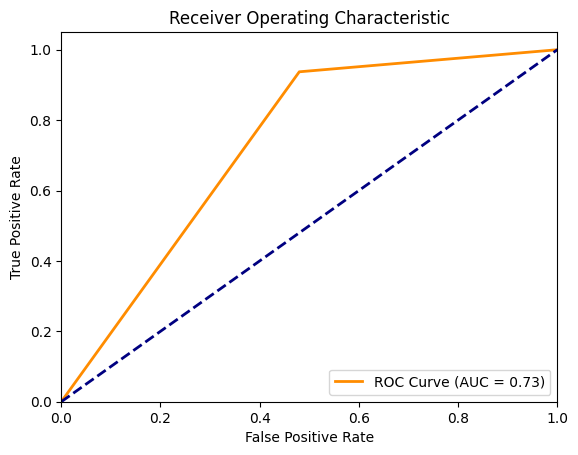

In [ ]:
#Compute Precision@K
def precision_at_k(predictions, k=10, threshold=best_threshold):
    user_precisions = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        relevance = (est >= threshold)
        user_precisions[uid].append((est, relevance))

    precision_scores = []
    for uid, user_ratings in user_precisions.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        num_relevant = sum((relevance for _, relevance in top_k))
        precision = num_relevant / k
        precision_scores.append(precision)

    return np.mean(precision_scores) if precision_scores else 0

precision_k = precision_at_k(predictions, k=10)
print(f"Precision@10: {precision_k:.4f}")

#Generate Top-N Recommendations for Users
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n_recommendations = get_top_n(predictions, n=10)

#Display Top-10 Recommendations for a Sample User
user_id = 123  # Example User ID
if user_id in top_n_recommendations:
    print(f"\n**Top 10 Recommendations for User {user_id}:**\n")
    for i, (song_id, score) in enumerate(top_n_recommendations[user_id], 1):
        print(f"{i}. Song ID: {song_id}, Predicted Score: {score:.3f}")
else:
    print(f"⚠ No recommendations for User {user_id}.")

#ROC Curve and AUC Visualization
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## ALS

In [ ]:
#Create Spark session
spark = SparkSession.builder.appName("MusicRecommender").getOrCreate()


In [ ]:
#Select relevant columns for the model
columns = ["user_id", "media_id", "is_listened"]
data_sample_prep_sel_als = data_sample_prep[columns]

#Convert is_listened from Boolean to Integer
data_sample_prep_sel_als["is_listened"] = data_sample_prep_sel_als["is_listened"].astype(int)

#Convert to a Spark DataFrame
df_spark = spark.createDataFrame(data_sample_prep_sel_als)

#Train-Test-Split
train, test = df_spark.randomSplit([0.8, 0.2], seed=42)

In [ ]:
#Create ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="media_id",
    ratingCol="is_listened",
    coldStartStrategy="drop"
)

#Train model
model = als.fit(train)

#Perform predictions on the test set
predictions = model.transform(test)

#F1 score optimization: Adjust threshold
best_threshold = 0.0
best_f1 = 0.0
thresholds = np.arange(0.1, 1.0, 0.1)

actual = predictions.select("is_listened").toPandas().values.flatten()

for threshold in thresholds:
    pred = predictions.select("prediction").toPandas().values.flatten()
    pred = np.where(pred >= threshold, 1, 0)
    f1 = f1_score(actual, pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

#Final predictions with the best threshold
final_pred = np.where(predictions.select("prediction").toPandas().values.flatten() >= best_threshold, 1, 0)

## Evaluation

In [31]:
#Calculation of the metrics
accuracy = accuracy_score(actual, final_pred)
precision = precision_score(actual, final_pred)
recall = recall_score(actual, final_pred)

print(f"Optimierter Threshold: {best_threshold}, Höchster F1-Score: {best_f1}")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

#End SparkSession
spark.stop()


Optimierter Threshold: 0.2, Höchster F1-Score: 0.8049963165360045
Accuracy: 0.6286238968900376, Precision: 0.6761707207295357, Recall: 0.8671635797821613
